In [ ]:
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
import os
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

df=pd.read_csv('/content/order_table_50k_v52.csv')
df.info() ##查看数据多少列，数据大小

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   order_id                   50000 non-null  int64  
 1   user_id                    50000 non-null  int64  
 2   order_date                 50000 non-null  object 
 3   age                        50000 non-null  float64
 4   fico_score                 50000 non-null  int64  
 5   vintage_score              50000 non-null  int64  
 6   ethnicity                  50000 non-null  object 
 7   medical_records_12m        50000 non-null  int64  
 8   income                     50000 non-null  int64  
 9   principal                  50000 non-null  int64  
 10  term                       50000 non-null  int64  
 11  interest                   50000 non-null  int64  
 12  order_status               50000 non-null  int64  
 13  fpd30                      50000 non-null  int

In [ ]:
# df.info() ##查看数据多少列，数据大小
df_pivot=df.groupby("education").agg(order_cnt=("order_id", "size"))
df_pivot

,order_cnt
education,
Undergraduate,13002
below_high_school,10058
graduate,3815
high_school,23125


In [ ]:
#column/feature names
a=list(df.columns)
a

['order_id',
 'user_id',
 'order_date',
 'age',
 'fico_score',
 'vintage_score',
 'ethnicity',
 'medical_records_12m',
 'income',
 'principal',
 'term',
 'interest',
 'order_status',
 'fpd30',
 'mob3_m2',
 'apply_amount',
 'control_group',
 'occupation',
 'credit_card_utilization',
 'credit_inquires_2years',
 'overdue_times_in_1year',
 'credit_account_avg_mth',
 'number_of_credit_accounts',
 'education']

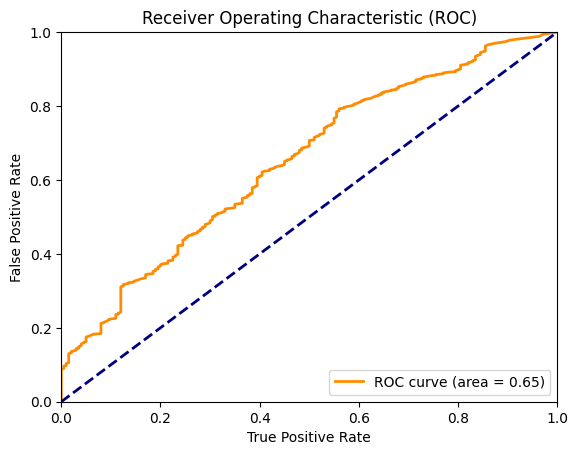

In [12]:
df=pd.read_csv('order_table_50k_v52.csv')
# df=df[(df['order_status']==1)]
df=df[(df['order_status']==1)&(df['control_group']==1)]
y_true = df['fpd30']  # 真实标签
y_scores = df['vintage_score']  # 预测分数 fico_score vintage_score
# 计算ROC曲线和AUC
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
roc_auc = metrics.auc(tpr,fpr)
# 绘制ROC曲线
plt.figure()
lw = 2
plt.plot(  tpr,fpr,color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#计算AUC
df=pd.read_csv('order_table_50k_v52.csv')
df=df[(df['order_status']==1)&(df['control_group']==0)]
score='fico_score'
try:
    auc = roc_auc_score(df['fpd30'], df[score])
    print(f"模型对label mob3_m2的AUC为: {1-auc}")
except ValueError as e:
    print(f"计算AUC时出现错误: {e}")
########################################################
#计算K-S
# 提取正例（标签为1）的预测分数
positive_scores = df[df['fpd30'] == 1][score]
# 提取所有样本的预测分数，用于形成对照组
all_scores = df[score]
# 计算K-S值
try:
    ks_statistic, ks_pvalue = ks_2samp(positive_scores, all_scores)
    print(f"KS统计量: {ks_statistic}, p值: {ks_pvalue}")
    # KS统计量越大，说明预测概率与实际标签的分离程度越好
    # p值用于检验假设检验的显著性，一般小于0.05认为两组分布有显著差异
except Exception as e:
    print(f"计算KS值时出现错误: {e}")

模型对label mob3_m2的AUC为: 0.6138477710559059
KS统计量: 0.17914230909755208, p值: 5.0379885278917115e-08


In [ ]:
#分10箱看风险
df=pd.read_csv('order_table_50k_v52.csv')
df=df[(df['order_status']==1)&(df['control_group']==0)]
bins = pd.qcut(df['vintage_score'], q=10, duplicates='drop')#等频10箱
df['bins']=bins
df_pivot=df[df['control_group']==0].groupby("bins").agg(order_cnt=("order_id", "size"),
                         approval_cnt=("order_status", "sum"),
                         fpd30=("fpd30", "sum"),
                         mob3_m2=("mob3_m2", "sum"),
                         principal=("principal", "sum")).reset_index()
df_pivot['fpd30_rate']=df_pivot['fpd30']/df_pivot['approval_cnt']
df_pivot['mob3_m2_rate']=df_pivot['mob3_m2']/df_pivot['approval_cnt']
df_pivot

/var/folders/f7/2frpmg2s6c74mpj4t1csv3x40000gp/T/ipykernel_82931/3026997728.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pivot=df[df['control_group']==0].groupby("bins").agg(order_cnt=("order_id", "size"),


,bins,order_cnt,approval_cnt,fpd30,mob3_m2,principal,fpd30_rate,mob3_m2_rate
0,"(499.999, 544.0]",2785,2785,60,138,9455300,0.021544,0.049551
1,"(544.0, 594.0]",2755,2755,33,99,9276500,0.011978,0.035935
2,"(594.0, 645.0]",2777,2777,41,93,9504700,0.014764,0.033489
3,"(645.0, 695.0]",2784,2784,31,77,9349400,0.011135,0.027658
4,"(695.0, 743.0]",2761,2761,30,82,9365100,0.010866,0.029699
5,"(743.0, 795.0]",2794,2794,16,57,9648400,0.005727,0.020401
6,"(795.0, 844.0]",2755,2755,21,56,9270200,0.007623,0.020327
7,"(844.0, 894.0]",2777,2777,15,50,9493600,0.005402,0.018005
8,"(894.0, 944.0]",2737,2737,22,54,9265600,0.008038,0.019730
9,"(944.0, 996.0]",2767,2767,3,10,9321500,0.001084,0.003614


# CASE1

In [ ]:
['order_id',
 'user_id',
 'order_date',
 'age',
 'fico_score',
 'vintage_score',
 'ethnicity',
 'medical_records_12m',
 'income',
 'principal',
 'term',
 'interest',
 'order_status',
 'fpd30',
 'mob3_m2',
 'apply_amount',
 'control_group',
 'occupation',
 'credit_card_utilization',
 'credit_inquires_2years',
 'overdue_times_in_1year',
 'credit_account_avg_mth',
 'number_of_credit_accounts',
 'education',
 'bins']

CASE 1的目标：调整X（自变量参数）来寻找到风险最大的节点；通过减少最少的人来降低风险，PD降低到2%以下

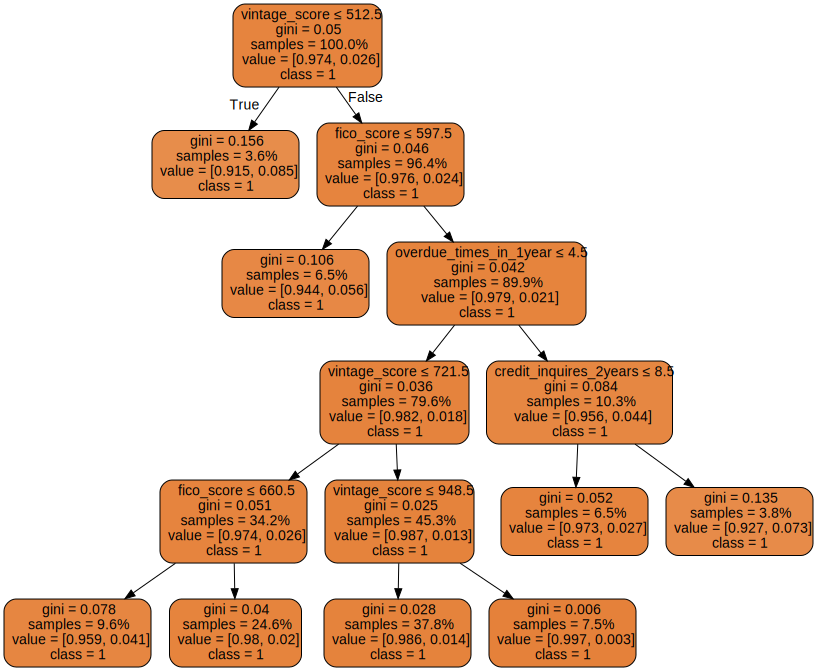

In [ ]:
df=pd.read_csv('order_table_50k_v52.csv')
df=df[(df['order_status']==1)&(df['control_group']==0)]
clf = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=1000,max_leaf_nodes=10)#更多调参细节https://www.jianshu.com/p/c12e1d4cc380
# x=['fico_score_fixed','vintage_score','medical_records_12m','income']#定义feature
x=['age',
 'fico_score',
 'vintage_score',
 'medical_records_12m',
 'income',
 # 'occupation',
 'credit_card_utilization',
 'credit_inquires_2years',
 'overdue_times_in_1year',
 'credit_account_avg_mth',
 'number_of_credit_accounts',
 # 'education'
  ]#定义feature
y='mob3_m2'#定义label
class_names=['1','0']  #列举y的枚举值，类比 1/0  （逾期/未逾期）
clf = clf.fit(df.loc[:,x], df[y])
# c_names= (['0', '1']) #y的枚举值
dot_data = tree.export_graphviz(clf, feature_names=x,class_names= class_names
                                ,out_file=None
                                ,proportion=True#True 比例 False 样本数
                                ,filled=True#填色
                                ,rounded=True#圆形图块
                                ,special_characters=True)
##输出pdf
graph = graphviz.Source(dot_data)
graph.render('test.ctree')
graph

In [19]:
#套入评价体系
df['s1']=np.where((df.vintage_score<721.5)&(df.fico_score<730.5),1,0)
df_pivot=df[df['control_group']==0].groupby("s1").agg(order_cnt=("order_id", "size"),
                         approval_cnt=("order_status", "sum"),
                         fpd30=("fpd30", "sum"),
                         mob3_m2=("mob3_m2", "sum"),
                         principal=("principal", "sum")).reset_index()
df_pivot['fpd30_rate']=df_pivot['fpd30']/df_pivot['approval_cnt']
df_pivot['mob3_m2_rate']=df_pivot['mob3_m2']/df_pivot['approval_cnt']
df_pivot

,s1,order_cnt,approval_cnt,fpd30,mob3_m2,principal,fpd30_rate,mob3_m2_rate
0,0,19250,19250,122,357,65403000,0.006338,0.018545
1,1,8442,8442,150,359,28547300,0.017768,0.042525


以上是不含有非数值（分类型）数据的分析

# CASE2

加入非数值型的数据进行参考

In [17]:
df=pd.read_csv('order_table_50k_v52.csv')
df=df[(df['order_status']==1)&(df['control_group']==0)]
df_pivot=df.groupby("occupation").agg(order_cnt=("order_id", "size"))
df_pivot #职业分类，主要是看是否是part time job

,order_cnt
occupation,
doctor,1597
farmer,10163
fisherman,4774
lawyer,293
parttime,10865


In [20]:
df=pd.read_csv('/content/order_table_50k_v52.csv')
df=df[(df['order_status']==1)&(df['control_group']==0)]
df['education_n']=np.where(df['education']=='below_high_school',1,
                              np.where(df['education']=='high_school',2,
                              np.where(df['education']=='Undergraduate',3,
                              np.where(df['education']=='graduate',4,0
                                      ))))
df = pd.get_dummies(df, columns=['occupation']) #分类，将小于高中的定义为1，高中定义为2，本科为3

In [ ]:
df.columns

Index(['order_id', 'user_id', 'order_date', 'age', 'fico_score',
       'vintage_score', 'ethnicity', 'medical_records_12m', 'income',
       'principal', 'term', 'interest', 'order_status', 'fpd30', 'mob3_m2',
       'apply_amount', 'control_group', 'credit_card_utilization',
       'credit_inquires_2years', 'overdue_times_in_1year',
       'credit_account_avg_mth', 'number_of_credit_accounts', 'education',
       'education_n', 'occupation_doctor', 'occupation_farmer',
       'occupation_fisherman', 'occupation_lawyer', 'occupation_parttime'],
      dtype='object')

In [21]:
df_pivot=df.groupby("occupation_parttime").agg(order_cnt=("order_id", "size"))
df_pivot #是否是parttime job

,order_cnt
occupation_parttime,
False,16827
True,10865


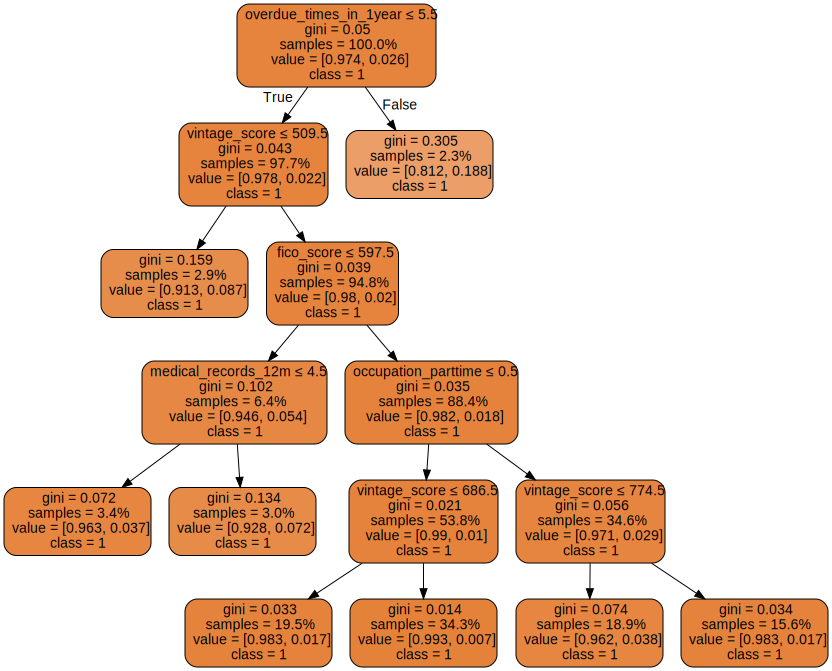

In [22]:
clf = tree.DecisionTreeClassifier(max_depth=5,min_samples_leaf=500,max_leaf_nodes=10)#更多调参细节https://www.jianshu.com/p/c12e1d4cc380
x=['age',
 'fico_score',
 'vintage_score',
 'medical_records_12m',
 'income',
 'credit_card_utilization',
 'credit_inquires_2years',
 'overdue_times_in_1year',
 'credit_account_avg_mth',
 'number_of_credit_accounts',
 'education_n',
 'occupation_doctor',
   'occupation_farmer',
 'occupation_fisherman',
   'occupation_lawyer',
   'occupation_parttime'
  ]#定义feature
y='mob3_m2'#定义label
class_names=['1','0']  #列举y的枚举值，类比 1/0  （逾期/未逾期）
clf = clf.fit(df.loc[:,x], df[y])
# c_names= (['0', '1']) #y的枚举值
dot_data = tree.export_graphviz(clf, feature_names=x,class_names= class_names
                                ,out_file=None
                                ,proportion=True#True 比例 False 样本数
                                ,filled=True#填色
                                ,rounded=True#圆形图块
                                ,special_characters=True)
##输出pdf
graph = graphviz.Source(dot_data)
graph.render('test.ctree')
graph

In [23]:
#套入评价体系
df['s1']=np.where((df.overdue_times_in_1year>=5.5)|
                  (((df.overdue_times_in_1year<5.5))&(df.vintage_score<509.5))|
                  (((df.overdue_times_in_1year<5.5))&(df.vintage_score>509.5)&(df.fico_score<=597.5)&(df.medical_records_12m>4.5))
                  ,1,0)
df_pivot=df[df['control_group']==0].groupby("s1").agg(order_cnt=("order_id", "size"),
                         approval_cnt=("order_status", "sum"),
                         fpd30=("fpd30", "sum"),
                         mob3_m2=("mob3_m2", "sum"),
                         principal=("principal", "sum")).reset_index()
df_pivot['fpd30_rate']=df_pivot['fpd30']/df_pivot['approval_cnt']
df_pivot['mob3_m2_rate']=df_pivot['mob3_m2']/df_pivot['approval_cnt']
df_pivot

,s1,order_cnt,approval_cnt,fpd30,mob3_m2,principal,fpd30_rate,mob3_m2_rate
0,0,25422,25422,156,467,86299600,0.006136,0.018370
1,1,2270,2270,116,249,7650700,0.051101,0.109692
